# Test PDPbox with binary classification problem
## Kaggle Titanic with XGBoost
This demo is based on **Titanic: Machine Learning from Disaster**  
https://www.kaggle.com/c/titanic/details/tutorials

In [1]:
import pandas as pd
from pdpbox import pdp, get_dataset, info_plots

# versions
- `xgboost`: 1.3.3
- `matplotlib`: 3.1.1
- `sklearn`: 0.23.1

In [2]:
import xgboost
from xgboost import XGBClassifier
print(xgboost.__version__)

1.3.3


In [3]:
import matplotlib
print(matplotlib.__version__)

3.1.1


In [4]:
import sklearn
print(sklearn.__version__)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

0.23.1


# train a simple xgboost classifier
We assume there is a `titanic` data folder under the same directory. The dataset is directly downloaded from kaggle with command `kaggle competitions download -c titanic`.

In [5]:
! ls titanic

gender_submission.csv  test.csv  train.csv


In [6]:
train_df = pd.read_csv('titanic/train.csv')
print(train_df.shape)
display(train_df.head())

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## simple feature engineering

In [7]:
titanic_data = train_df.copy()
titanic_data = titanic_data.drop('Cabin', axis=1)
titanic_data['Age'] = titanic_data['Age'].fillna(titanic_data['Age'].median())
titanic_data['Embarked']= titanic_data['Embarked'].fillna(titanic_data['Embarked'].value_counts().index[0])
LE = LabelEncoder()
titanic_data['Sex'] = LE.fit_transform(titanic_data['Sex'])
for v in ['C', 'S', 'Q']:
    titanic_data['Embarked_{}'.format(v)] = (titanic_data['Embarked'] == v).map(int)

In [8]:
features= ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_S', 'Embarked_Q']
target = ['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    titanic_data[features], titanic_data[target], test_size = 0.2, random_state=42)

## model training

In [9]:
%%time
classifier = XGBClassifier(
    max_depth=12,
    subsample=0.33,
    objective='binary:logistic',
    n_estimators=100,
    learning_rate = 0.01)
eval_set = [(X_train,y_train), (X_test,y_test)]

classifier.fit(
    X_train, y_train.values.ravel(), 
    early_stopping_rounds=12, 
    eval_metric=["error", "logloss"],
    eval_set=eval_set, 
    verbose=True
)
classifier.score(X_test,y_test)

[0]	validation_0-error:0.18961	validation_0-logloss:0.68866	validation_1-error:0.18436	validation_1-logloss:0.68878
[1]	validation_0-error:0.17275	validation_0-logloss:0.68393	validation_1-error:0.20112	validation_1-logloss:0.68471
[2]	validation_0-error:0.16011	validation_0-logloss:0.67956	validation_1-error:0.21229	validation_1-logloss:0.68080
[3]	validation_0-error:0.16714	validation_0-logloss:0.67487	validation_1-error:0.22346	validation_1-logloss:0.67658
[4]	validation_0-error:0.16011	validation_0-logloss:0.67035	validation_1-error:0.22905	validation_1-logloss:0.67301
[5]	validation_0-error:0.16292	validation_0-logloss:0.66637	validation_1-error:0.22346	validation_1-logloss:0.66934
[6]	validation_0-error:0.15449	validation_0-logloss:0.66224	validation_1-error:0.22346	validation_1-logloss:0.66533
[7]	validation_0-error:0.16714	validation_0-logloss:0.65806	validation_1-error:0.22905	validation_1-logloss:0.66152
[8]	validation_0-error:0.15871	validation_0-logloss:0.65453	validation_1

[71]	validation_0-error:0.14466	validation_0-logloss:0.49279	validation_1-error:0.21229	validation_1-logloss:0.51357
[72]	validation_0-error:0.14466	validation_0-logloss:0.49121	validation_1-error:0.21229	validation_1-logloss:0.51218
[73]	validation_0-error:0.14466	validation_0-logloss:0.48957	validation_1-error:0.21229	validation_1-logloss:0.51068
[74]	validation_0-error:0.14888	validation_0-logloss:0.48783	validation_1-error:0.21229	validation_1-logloss:0.50929
[75]	validation_0-error:0.14607	validation_0-logloss:0.48646	validation_1-error:0.21229	validation_1-logloss:0.50813
[76]	validation_0-error:0.14607	validation_0-logloss:0.48476	validation_1-error:0.21229	validation_1-logloss:0.50678
[77]	validation_0-error:0.14747	validation_0-logloss:0.48326	validation_1-error:0.21229	validation_1-logloss:0.50562
[78]	validation_0-error:0.14888	validation_0-logloss:0.48195	validation_1-error:0.21229	validation_1-logloss:0.50453
[79]	validation_0-error:0.14747	validation_0-logloss:0.48033	val

In [10]:
titanic_features = features
titanic_model = classifier
titanic_target = 'Survived'

# [for internal usage] dump to `.pkl` for unit test

# or you can directory load the data and model

In [5]:
test_titanic = get_dataset.titanic()
print(test_titanic.keys())

dict_keys(['data', 'features', 'target', 'xgb_model'])


In [6]:
titanic_data = test_titanic['data']
titanic_features = test_titanic['features']
titanic_model = test_titanic['xgb_model']
titanic_target = test_titanic['target']

# 1. Binary feature: Sex

## 1.1 target distribution through feature 'Sex'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


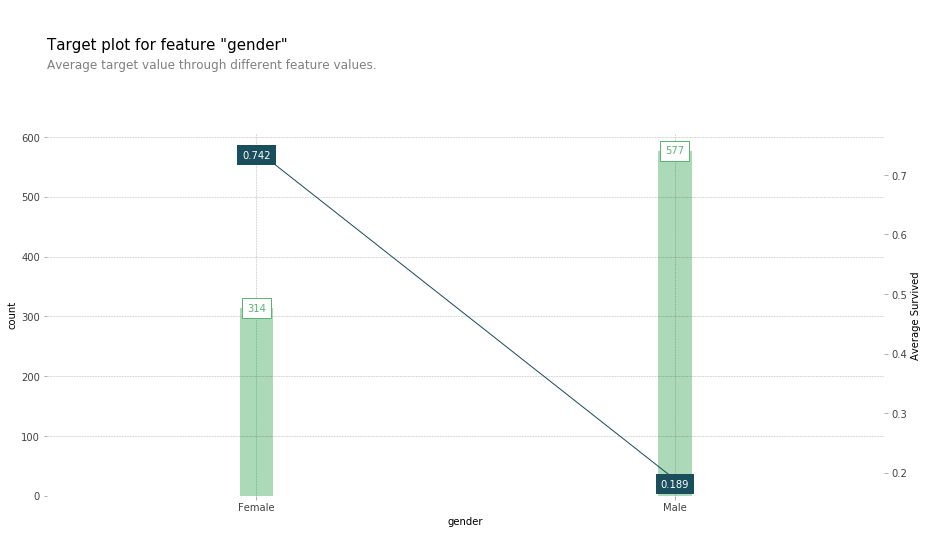

In [7]:
fig, axes, summary_df = info_plots.target_plot(
    df=titanic_data, feature='Sex', feature_name='gender', target=titanic_target
)
_ = axes['bar_ax'].set_xticklabels(['Female', 'Male'])

In [8]:
summary_df

,x,display_column,count,Survived
0,0,Sex_0,314,0.742038
1,1,Sex_1,577,0.188908


## 1.2 check prediction distribution through feature 'Sex'

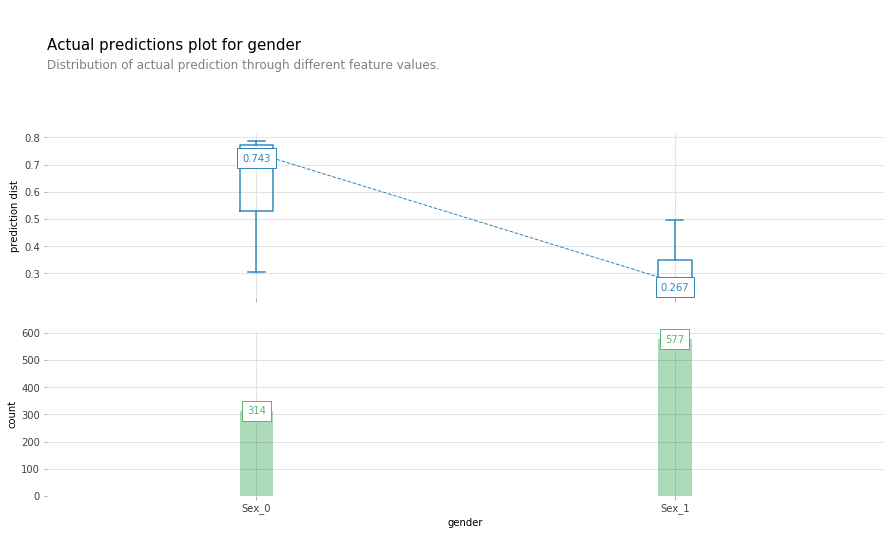

In [9]:
fig, axes, summary_df = info_plots.actual_plot(
    model=titanic_model, X=titanic_data[titanic_features], feature='Sex', feature_name='gender'
)

In [10]:
summary_df

,x,display_column,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,Sex_0,314,0.529746,0.742535,0.770870
1,1,Sex_1,577,0.251237,0.267264,0.350209


## 1.3 pdp for feature 'Sex'

In [11]:
pdp_sex = pdp.pdp_isolate(
    model=titanic_model, dataset=titanic_data, model_features=titanic_features, feature='Sex'
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


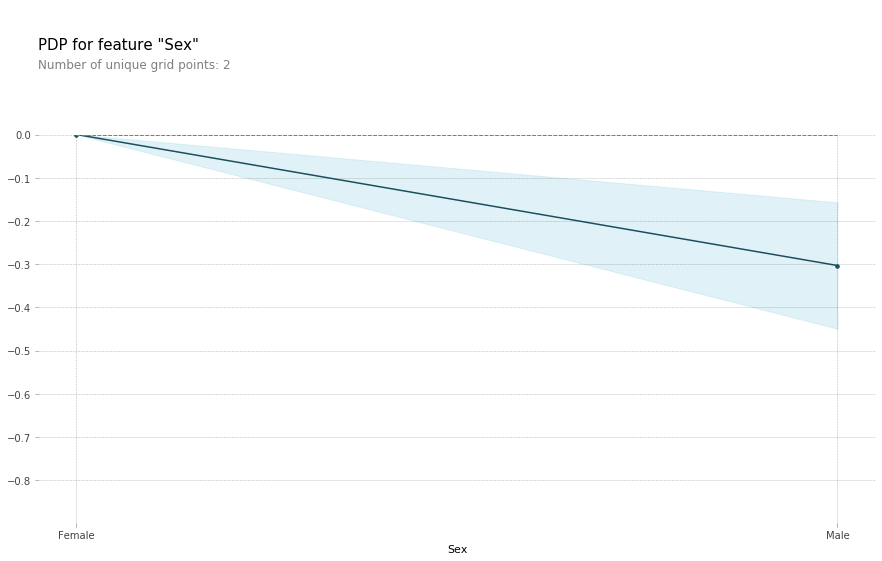

In [12]:
# default
fig, axes = pdp.pdp_plot(pdp_sex, 'Sex')
_ = axes['pdp_ax'].set_xticklabels(['Female', 'Male'])

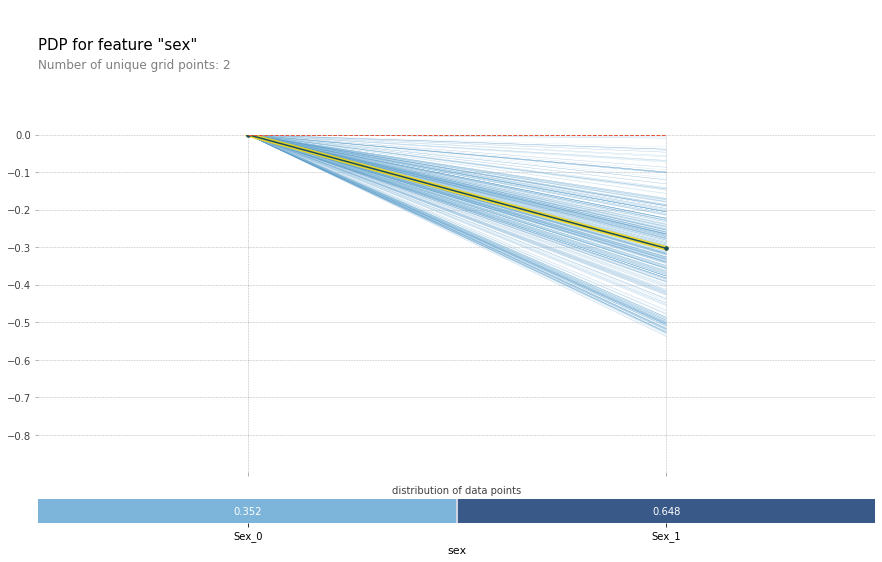

In [13]:
# more info
fig, axes = pdp.pdp_plot(pdp_sex, 'sex', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)

# 2. one-hot encoding feature: embarked
for one-hot encoding feature, should provide a list containing all the related columns

## 2.1 target distribution through feature 'embarked'

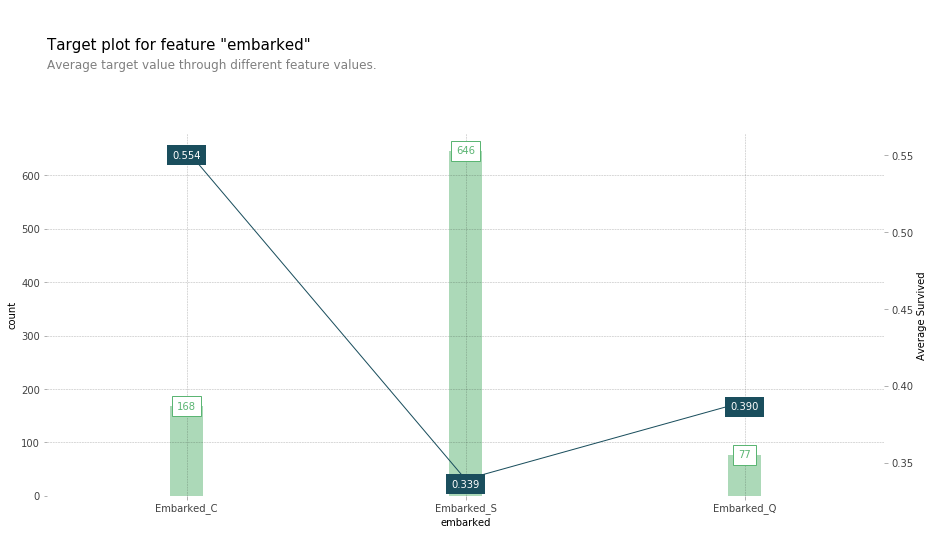

In [14]:
fig, axes, summary_df = info_plots.target_plot(
    df=titanic_data, feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'], feature_name='embarked', 
    target=titanic_target
)

In [15]:
summary_df

,x,display_column,count,Survived
0,0,Embarked_C,168,0.553571
1,1,Embarked_S,646,0.339009
2,2,Embarked_Q,77,0.389610


## 2.2 check prediction distribution through feature 'embarked'

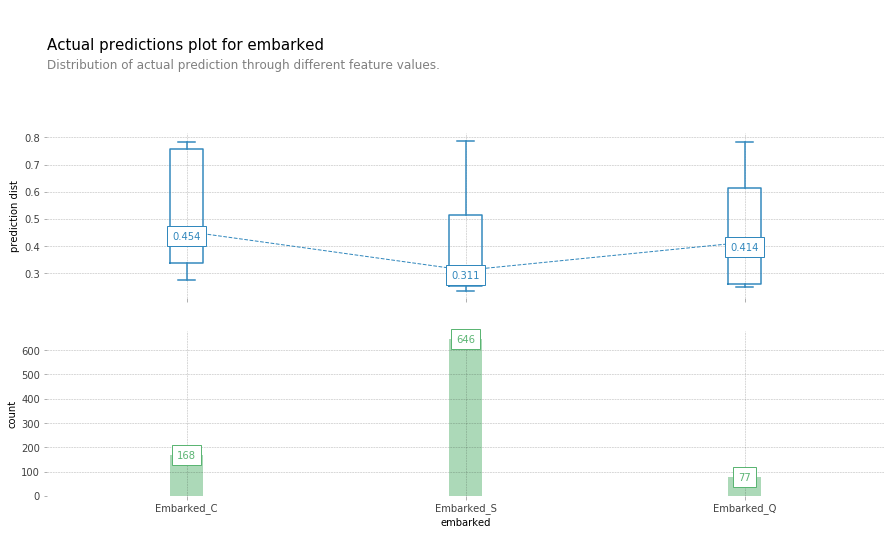

In [16]:
fig, axes, summary_df = info_plots.actual_plot(
    model=titanic_model, X=titanic_data[titanic_features], feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'], 
    feature_name='embarked'
)

In [17]:
summary_df

,x,display_column,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,Embarked_C,168,0.337831,0.453932,0.755985
1,1,Embarked_S,646,0.253127,0.310692,0.512606
2,2,Embarked_Q,77,0.258811,0.413767,0.612809


## 2.3 pdp for feature 'embarked'

In [18]:
pdp_embark = pdp.pdp_isolate(
    model=titanic_model, dataset=titanic_data, model_features=titanic_features, 
    feature=['Embarked_C', 'Embarked_S', 'Embarked_Q']
)

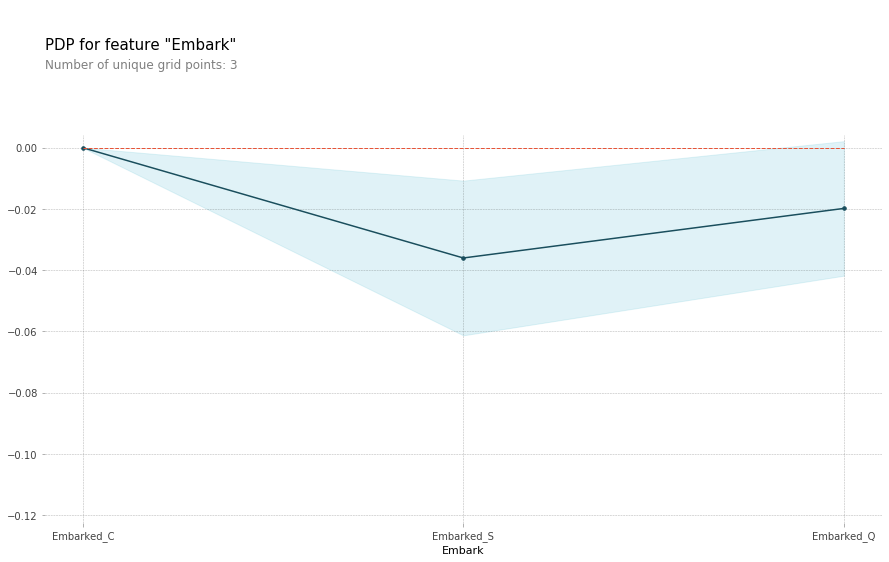

In [19]:
fig, axes = pdp.pdp_plot(pdp_embark, 'Embark')

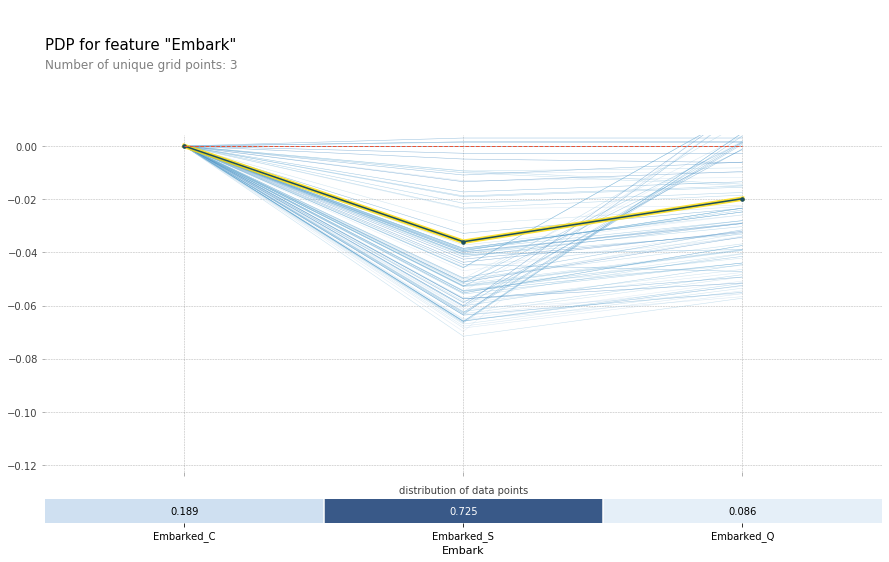

In [20]:
fig, axes = pdp.pdp_plot(pdp_embark, 'Embark', center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

# 3. numeric feature: Fare

## 3.1 target distribution through feature 'Fare'

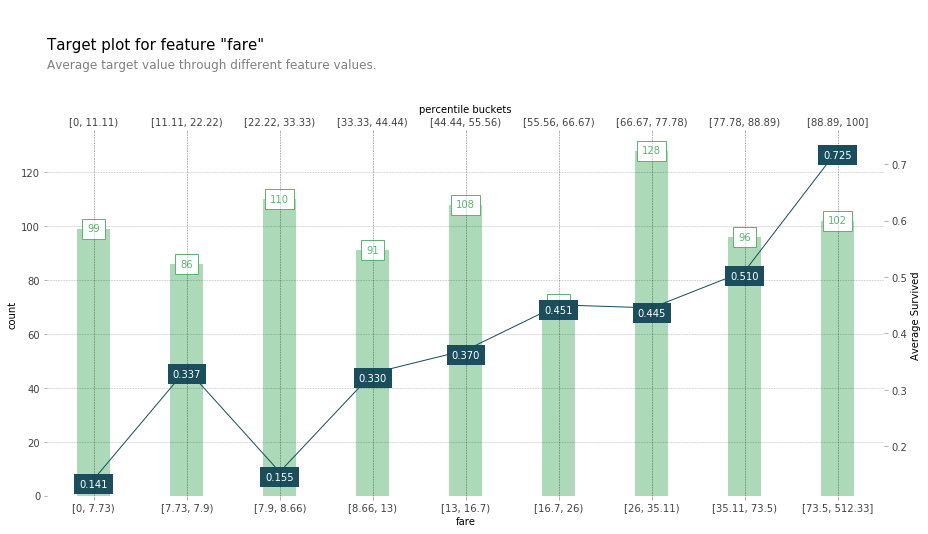

In [21]:
fig, axes, summary_df = info_plots.target_plot(
    df=titanic_data, feature='Fare', feature_name='fare', target=titanic_target, show_percentile=True
)

In [22]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,Survived
0,0,"[0, 7.73)",0.000000,7.732844,"[0, 11.11)",0.00,11.11,99,0.141414
1,1,"[7.73, 7.9)",7.732844,7.895800,"[11.11, 22.22)",11.11,22.22,86,0.337209
2,2,"[7.9, 8.66)",7.895800,8.662500,"[22.22, 33.33)",22.22,33.33,110,0.154545
3,3,"[8.66, 13)",8.662500,13.000000,"[33.33, 44.44)",33.33,44.44,91,0.329670
4,4,"[13, 16.7)",13.000000,16.700000,"[44.44, 55.56)",44.44,55.56,108,0.370370
5,5,"[16.7, 26)",16.700000,26.000000,"[55.56, 66.67)",55.56,66.67,71,0.450704
6,6,"[26, 35.11)",26.000000,35.111111,"[66.67, 77.78)",66.67,77.78,128,0.445312
7,7,"[35.11, 73.5)",35.111111,73.500000,"[77.78, 88.89)",77.78,88.89,96,0.510417
8,8,"[73.5, 512.33]",73.500000,512.329200,"[88.89, 100]",88.89,100.00,102,0.725490


## 3.2 check prediction distribution through feature 'Fare'

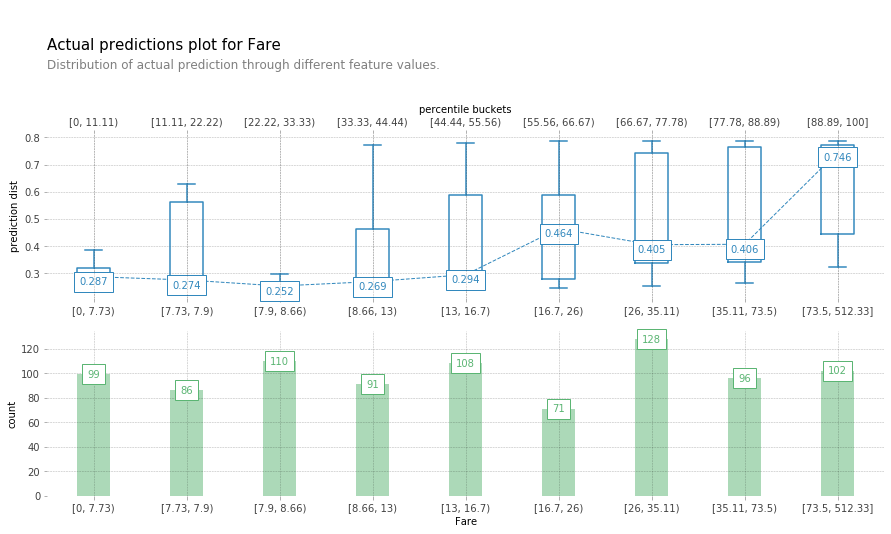

In [23]:
fig, axes, summary_df = info_plots.actual_plot(
    model=titanic_model, X=titanic_data[titanic_features], feature='Fare', feature_name='Fare', 
    show_percentile=True
)

In [24]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,"[0, 7.73)",0.000000,7.732844,"[0, 11.11)",0.00,11.11,99,0.253739,0.286751,0.317591
1,1,"[7.73, 7.9)",7.732844,7.895800,"[11.11, 22.22)",11.11,22.22,86,0.258811,0.274496,0.562648
2,2,"[7.9, 8.66)",7.895800,8.662500,"[22.22, 33.33)",22.22,33.33,110,0.245521,0.252387,0.265690
3,3,"[8.66, 13)",8.662500,13.000000,"[33.33, 44.44)",33.33,44.44,91,0.249461,0.268690,0.462660
4,4,"[13, 16.7)",13.000000,16.700000,"[44.44, 55.56)",44.44,55.56,108,0.250826,0.293962,0.588795
5,5,"[16.7, 26)",16.700000,26.000000,"[55.56, 66.67)",55.56,66.67,71,0.277722,0.463934,0.587410
6,6,"[26, 35.11)",26.000000,35.111111,"[66.67, 77.78)",66.67,77.78,128,0.338511,0.404576,0.742940
7,7,"[35.11, 73.5)",35.111111,73.500000,"[77.78, 88.89)",77.78,88.89,96,0.341277,0.406147,0.762725
8,8,"[73.5, 512.33]",73.500000,512.329200,"[88.89, 100]",88.89,100.00,102,0.443956,0.746002,0.771691


## 3.3 pdp for feature 'Fare'

In [25]:
pdp_fare = pdp.pdp_isolate(
    model=titanic_model, dataset=titanic_data, model_features=titanic_features, feature='Fare'
)

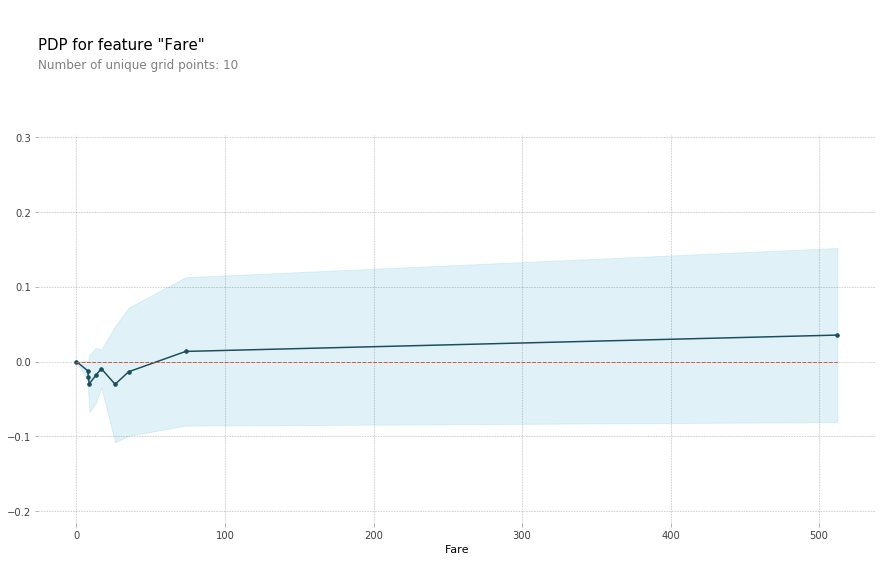

In [26]:
fig, axes = pdp.pdp_plot(pdp_fare, 'Fare')

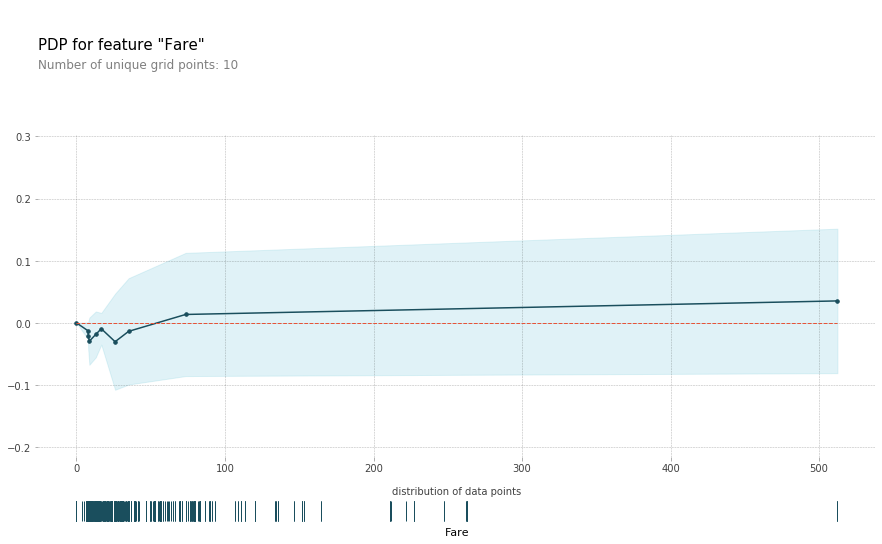

In [27]:
fig, axes = pdp.pdp_plot(pdp_fare, 'Fare', plot_pts_dist=True)

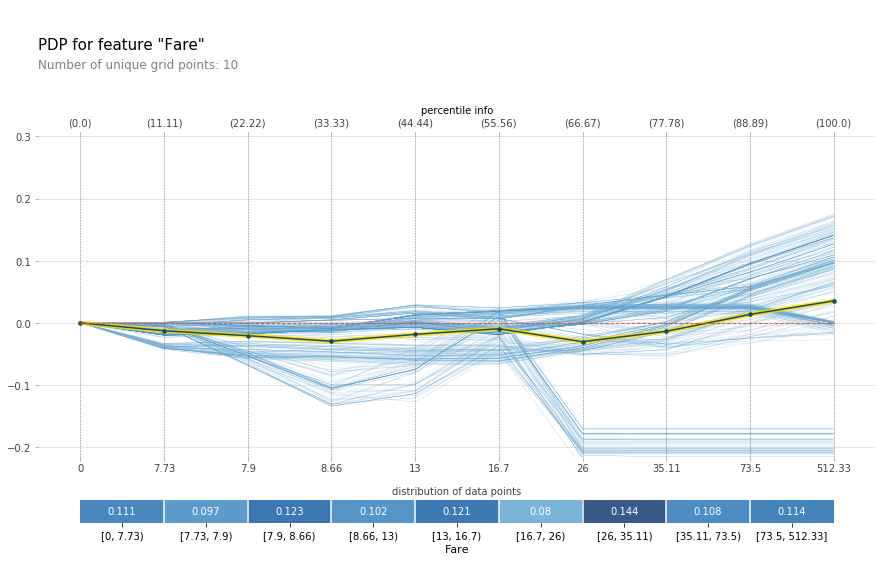

In [28]:
fig, axes = pdp.pdp_plot(
    pdp_fare, 'Fare', frac_to_plot=0.5, plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True
)

# 4. Interaction between two variables: Age and Fare

## 4.1 target distribution through feature combination of 'Age' and 'Fare'

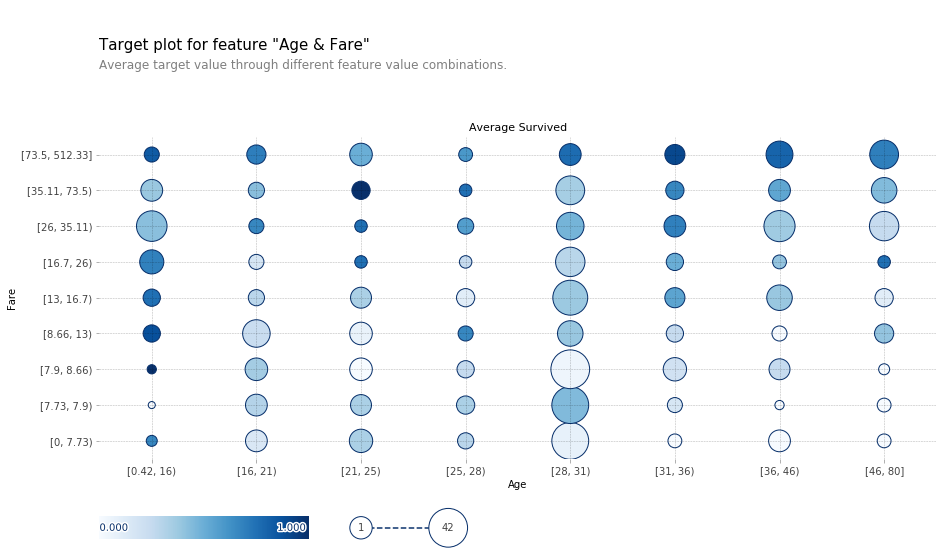

In [29]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=titanic_data, features=['Age', 'Fare'], feature_names=['Age', 'Fare'], target=titanic_target
)

In [30]:
summary_df.head()

,x1,x2,display_column_1,display_column_2,value_lower_1,value_upper_1,value_lower_2,value_upper_2,count,Survived
0,0,0,"[0.42, 16)","[0, 7.73)",0.42,16.0,0.000000,7.732844,3,0.666667
1,0,1,"[0.42, 16)","[7.73, 7.9)",0.42,16.0,7.732844,7.895800,1,0.000000
2,0,2,"[0.42, 16)","[7.9, 8.66)",0.42,16.0,7.895800,8.662500,2,1.000000
3,0,3,"[0.42, 16)","[8.66, 13)",0.42,16.0,8.662500,13.000000,8,0.875000
4,0,4,"[0.42, 16)","[13, 16.7)",0.42,16.0,13.000000,16.700000,8,0.750000


## 4.2 prediction distribution through feature combination of 'Age' and 'Fare'

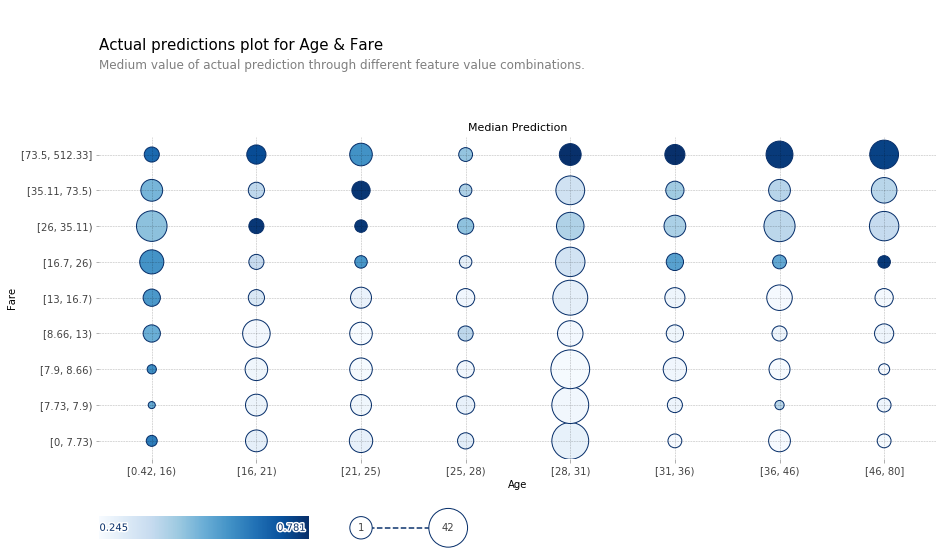

In [31]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=titanic_model, X=titanic_data[titanic_features], features=['Age', 'Fare'], feature_names=['Age', 'Fare']
)

In [32]:
summary_df.head()

,x1,x2,display_column_1,display_column_2,value_lower_1,value_upper_1,value_lower_2,value_upper_2,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,0,"[0.42, 16)","[0, 7.73)",0.42,16.0,0.000000,7.732844,3,0.503831,0.623744,0.623744
1,0,1,"[0.42, 16)","[7.73, 7.9)",0.42,16.0,7.732844,7.895800,1,0.523373,0.523373,0.523373
2,0,2,"[0.42, 16)","[7.9, 8.66)",0.42,16.0,7.895800,8.662500,2,0.569270,0.587743,0.606216
3,0,3,"[0.42, 16)","[8.66, 13)",0.42,16.0,8.662500,13.000000,8,0.500967,0.514344,0.544153
4,0,4,"[0.42, 16)","[13, 16.7)",0.42,16.0,13.000000,16.700000,8,0.473476,0.565033,0.614963


## 4.3 pdp for feature combination of 'Age' and 'Fare'

In [33]:
inter1 = pdp.pdp_interact(
    model=titanic_model, dataset=titanic_data, model_features=titanic_features, features=['Age', 'Fare']
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


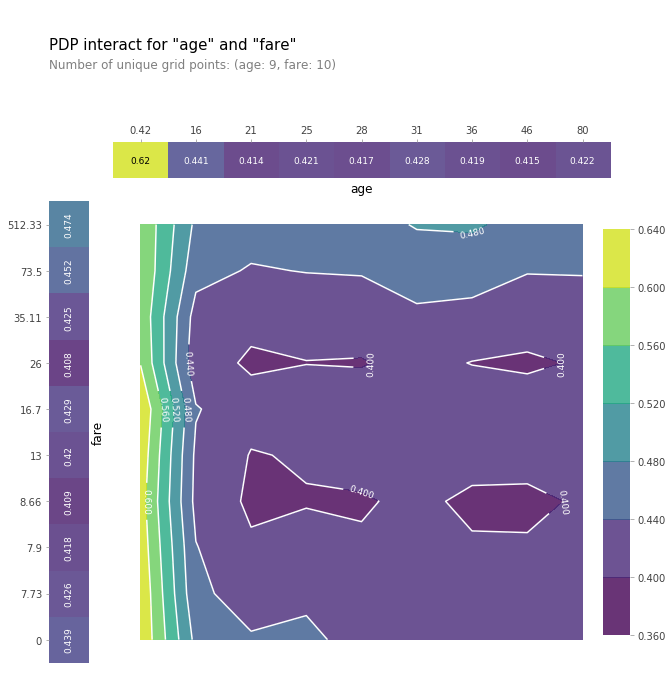

In [34]:
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=inter1, feature_names=['age', 'fare'], plot_type='contour', x_quantile=True, plot_pdp=True
)

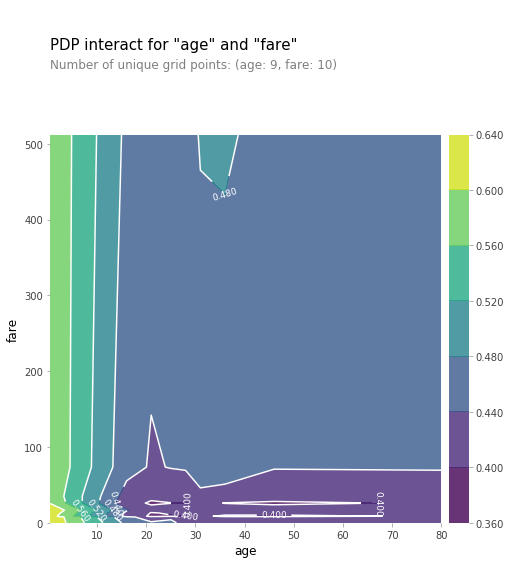

In [35]:
fig, axes = pdp.pdp_interact_plot(inter1, ['age', 'fare'], plot_type='contour', x_quantile=False, plot_pdp=False)

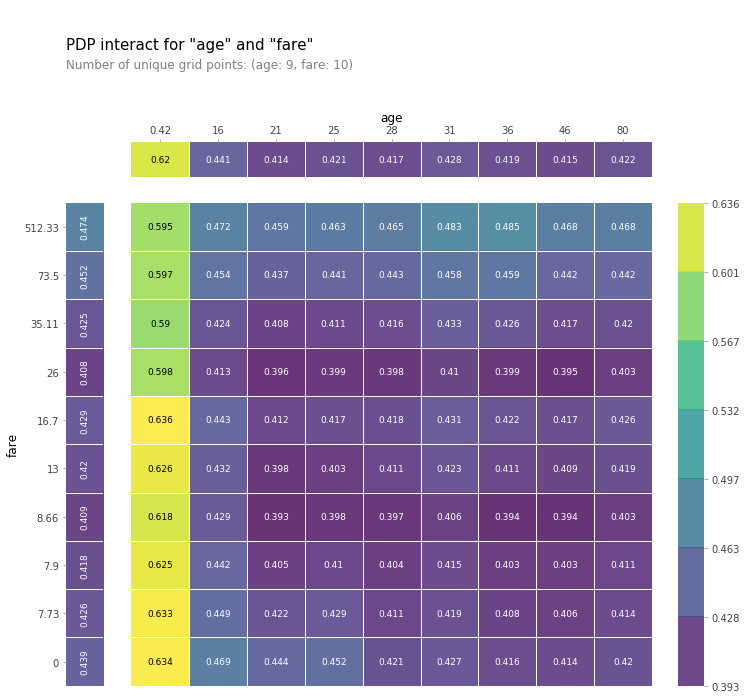

In [36]:
fig, axes = pdp.pdp_interact_plot(inter1, ['age', 'fare'], plot_type='grid', x_quantile=True, plot_pdp=True)